***Calibrate Camera***

In [ ]:
import numpy as np
import cv2 as cv
import glob

# Criteria for the termination of the iterative algorithm
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0), ..., (9,6,0)
objp = np.zeros((6 * 9, 3), np.float32)  # Change the size to 9 columns
objp[:, :2] = np.mgrid[0:9, 0:6].T.reshape(-1, 2)

# Arrays to store object points and image points from all the images
objpoints = []  # 3D points in real-world space
imgpoints = []  # 2D points in image plane

# Load images from a directory
images = glob.glob('/content/*.png')
print("Found images:", images)

for fname in images:
    img = cv.imread(fname)
    if img is None:
        print(f"Failed to load image: {fname}")
        continue

    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv.findChessboardCorners(gray, (9, 6), None)  # Updated to (9, 6)

    # If found, add object points and image points (after refining them)
    if ret:
        print(f"Chessboard corners found in {fname}")
        objpoints.append(objp)

        corners2 = cv.cornerSubPix(gray, corners, (11, 11), (-1, -1), criteria)
        imgpoints.append(corners2)

        # Draw and display the corners
        cv.drawChessboardCorners(img, (9, 6), corners2, ret)  # Updated to (9, 6)
        # cv.imshow('Corners found', img)
        # cv.waitKey(500)
    else:
        print(f"Chessboard corners not found in {fname}")
        # Display the image to see if the chessboard is present
        # cv.imshow('Image without corners', img)
        # cv.waitKey(500)

# Check if any corners were found before calibration
if len(imgpoints) > 0:
    # Use the dimensions of the last processed image for camera calibration
    ret, matrix, distortion, r_vecs, t_vecs = cv.calibrateCamera(
        objpoints, imgpoints, gray.shape[::-1], None, None)

    # Display the required output
    print("Camera matrix:")
    print(matrix)

    print("\nDistortion coefficients:")
    print(distortion)

    print("\nRotation Vectors:")
    print(r_vecs)

    print("\nTranslation Vectors:")
    print(t_vecs)
else:
    print("No valid images found for calibration.")

cv.destroyAllWindows()  # Close all OpenCV windows


Found images: ['/content/cam_calibe4.png', '/content/cam_calibe8.png', '/content/im1.png', '/content/cam_calibe9.png', '/content/cam_calibe7.png', '/content/cam_calibe3.png', '/content/cam_calibe1.png', '/content/cam_calibe2.png', '/content/im0.png']
Chessboard corners found in /content/cam_calibe4.png
Chessboard corners not found in /content/cam_calibe8.png
Chessboard corners not found in /content/im1.png
Chessboard corners found in /content/cam_calibe9.png
Chessboard corners not found in /content/cam_calibe7.png
Chessboard corners found in /content/cam_calibe3.png
Chessboard corners found in /content/cam_calibe1.png
Chessboard corners found in /content/cam_calibe2.png
Chessboard corners not found in /content/im0.png
Camera matrix:
[[1.54960068e+03 0.00000000e+00 1.51523590e+03]
 [0.00000000e+00 6.71255792e+03 1.07394234e+03]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00]]

Distortion coefficients:
[[-0.13019088 -0.11665179 -0.02577449 -0.03047579  0.0534775 ]]

Rotation Vectors:
(ar

***Depth Map (Using Stereo VIsion)***

Left image shape: (2008, 2988), Right image shape: (2008, 2988)


<ipython-input-19-ffa7241a0993>:45: RuntimeWarning:

divide by zero encountered in divide



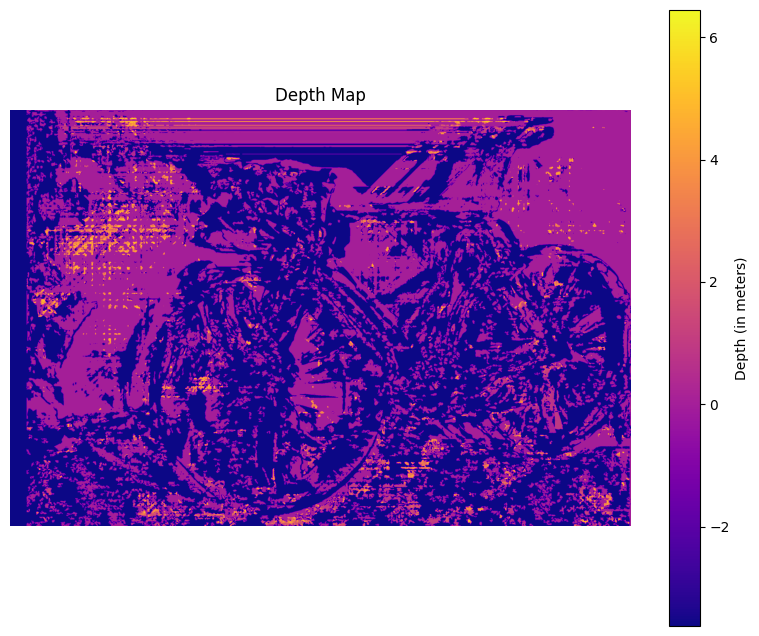

In [19]:
import matplotlib.pyplot as plt

# Load the left and right images (make sure to use your own image paths)
left_image_path = '/content/im1.png'
right_image_path = '/content/im0.png'

# Load images
img_left = cv.imread(left_image_path, cv.IMREAD_GRAYSCALE)
img_right = cv.imread(right_image_path, cv.IMREAD_GRAYSCALE)
# Check the shape of the images
print(f"Left image shape: {img_left.shape}, Right image shape: {img_right.shape}")

# Resize images if they are not the same size
if img_left.shape != img_right.shape:
    img_right = cv.resize(img_right, (img_left.shape[1], img_left.shape[0]))

# Camera parameters based on your calibration
camera_matrix = np.array([[ 36.26378216,   0,         125.68539168],
 [  0,          36.76607372, 142.49821147],
 [  0,           0,           1        ]])
dist_coeffs = np.array([-1.25491812e-03,  9.89269357e-05, -2.89077718e-03,  4.52760939e-04, -3.29964245e-06])

# StereoSGBM parameters
min_disparity = 0
num_disparities = 16 * 5  # Must be divisible by 16
block_size = 11  # Size of the block
stereo = cv.StereoSGBM_create(minDisparity=min_disparity,
                               numDisparities=num_disparities,
                               blockSize=block_size,
                               P1=8 * 3 * block_size ** 2,
                               P2=32 * 3 * block_size ** 2,
                               disp12MaxDiff=1,
                               uniquenessRatio=10,
                               speckleWindowSize=100,
                               speckleRange=32,
                               mode=cv.STEREO_SGBM_MODE_SGBM)

# Compute disparity map
disparity = stereo.compute(img_left, img_right).astype(np.float32) / 16.0

# Generate depth map (assuming a baseline distance 'b' in meters)
focal_length = camera_matrix[0, 0]  # Focal length from the camera matrix
baseline = 0.1  # Example baseline in meters (distance between cameras)

depth_map = (focal_length * baseline) / disparity
depth_map[disparity == 0] = 0  # Avoid division by zero
plt.figure(figsize=(10, 8))
plt.imshow(depth_map, cmap='plasma')
plt.colorbar(label='Depth (in meters)')
plt.title('Depth Map')
plt.axis('off')  # Turn off axis
plt.show()


In [20]:
depth_map[depth_map < 0] = 0

# Optional: Clip depth values to a valid range if needed
# depth_map = np.clip(depth_map, 0, None)  # Ensures all values are non-negative


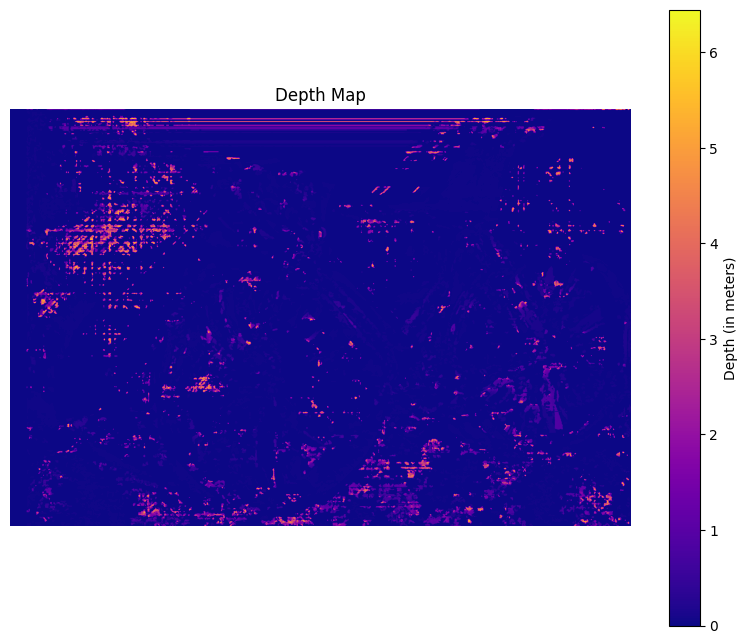

In [21]:
plt.figure(figsize=(10, 8))
plt.imshow(depth_map, cmap='plasma')
plt.colorbar(label='Depth (in meters)')
plt.title('Depth Map')
plt.axis('off')  # Turn off axis
plt.show()


***Install Open3D***

In [ ]:
!pip install open3d


  Using cached jedi-0.19.1-py2.py3-none-any.whl.metadata (22 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 399.7/399.7 MB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 72.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 50.0 MB/s eta 0:00:00
Using cached jedi-0.19.1-py2.py3-none-any.whl (1.6 MB)
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.9
    Uninstalling widgetsnbextension-3.6.9:
      Successfully uninstalled widgetsnbextension-3.6.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [ ]:

!apt-get install -y xvfb ffmpeg libsm6 libxext6
!pip install PyVirtualDisplay


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
libsm6 is already the newest version (2:1.2.3-1build2).
libxext6 is already the newest version (2:1.3.4-1build1).
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
The following additional packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common
The following NEW packages will be installed:
  libfontenc1 libxfont2 libxkbfile1 x11-xkb-utils xfonts-base xfonts-encodings xfonts-utils
  xserver-common xvfb
0 upgraded, 9 newly installed, 0 to remove and 49 not upgraded.
Need to get 7,813 kB of archives.
After this operation, 11.9 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/main amd64 libfontenc1 amd64 1:1.1.4-1build3 [14.7 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/main amd64 libxfont2 amd64 1:2.0.5-1build1 [94.5 kB]
Get:3 http://archive.ubuntu.com/ubunt

In [ ]:
!pip install plotly


***Using Open3D convert the Depth map to Pcl***

In [22]:
import open3d as o3d
import plotly.graph_objs as go
import plotly.offline as pyo
import pandas as pd
import plotly.express as px

height, width = depth_map.shape
intrinsics = o3d.camera.PinholeCameraIntrinsic(width, height,
                                                camera_matrix[0, 0], camera_matrix[1, 1],
                                                camera_matrix[0, 2], camera_matrix[1, 2])
point_cloud = o3d.geometry.PointCloud.create_from_depth_image(
    o3d.geometry.Image(depth_map),
    intrinsics)
point_cloud = point_cloud.voxel_down_sample(voxel_size=0.1)
# Convert Open3D PointCloud to NumPy arrays
points = np.asarray(point_cloud.points)
colors = np.asarray(point_cloud.colors) if point_cloud.has_colors() else np.ones((points.shape[0], 3))  # Default to white

print(len(points))
print(len(colors))
# Visualize the point cloud using Open3D
# o3d.visualization.draw_geometries([point_cloud])
points_df = pd.DataFrame(points, columns=['x', 'y', 'z'])

# Create a 3D scatter plot
fig = px.scatter_3d(points_df, x='x', y='y', z='z', color='z', color_continuous_scale='Viridis', title='3D Point Cloud')
fig.show()

Output hidden; open in https://colab.research.google.com to view.

In [23]:
print("Depth Map Stats:")
print(f"Min Depth: {np.min(depth_map)}")
print(f"Max Depth: {np.max(depth_map)}")


Depth Map Stats:
Min Depth: 0.0
Max Depth: 6.446894645690918
